In [2]:
from scipy import stats
from Models import Model
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import ABC

# silence warnings about dodgy division
np.seterr(divide='ignore', invalid='ignore')

# Size plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100

In [11]:
def ci_parameters(accepted_values,alpha=.05,weights=None):
    
    if (weights):
        zipped = zip(ar, weights)
        weighted = []
        for (a, w) in zipped:
            w*=1000
            for j in range(w):
                weighted.append(a)
    else: weighted=accepted_values
    
    ub=np.percentile(weighted,100*(1-alpha/2),axis=0)
    lb=np.percentile(weighted,100*(alpha/2),axis=0)
    
    return (lb,ub)

# SIR Modelling and ABC
*Compartmental Models* are a class of mathematical models used for modelling infectious diseases where each member of the population are assigned to different classes. The SIR Model is a compartmental model where members of the population are either **S**usceptible, **I**nfectious or **R**ecovered.

**Table of Contents**
 * [Motivation](#Motivation)
 * [The SIR Model](#The-SIR-Model)
   * [Specification](#Specification)
   * [Implementation](#SIR-Implementation)
   * [Basic Reproduction Number $R_0$](#Basic-Reproduction-Number-$R_0$)
 * [SIR and ABC](#SIR-and-ABC)
   * [Implementation](#SIR-and-ABC-Implementation)
     * [ABC-Rejection Algorithm](#ABC-Rejection-Algorithm)
     * [ABC-MCMC](#ABC-MCMC)
     * [ABC-SMC](#ABC-SMC)
     * [Adaptive AMC-SMC](#Adaptive-ABC-SMC)
   * [Better Summary Statistics](#Better-Summary-Statistics)
     * [Peaks](#better_ss_peaks)
     * [Acutal Peak](#better_ss_acutal_peak)
     * [Other](#Other)
 * [Discussion](#Discussion)
     * [Limitation](#Limitations)
     * [Extensions to the SIR Model](#Extensions-to-the-SIR-Model)
     * [Extensions to the ABC Methods](#Extensions-to-the-ABC-Methods)
     * [Other Epidemic Models](#Other-Epidemic-Models)

## Motivation

Generally assume the Markov property (ie values at time $t+1$ only depend on values at time $t$).

## The SIR Model
Here I present the classical SIR model which uses ordinary differential equations.

### Specification

Compartmental models are used to model individuals in a population. Each model defines a set of classes which partition the population and defines the mechanics by which individuals can move between populations. Compartmental models are often used to model the spread of something through a population, notably infectious diseases.

I shall present the SIR model for the problem of modelling infectious diseases.

**Classes**

The SIR model is one of the simpliest (but still powerful) compartmental models which uses three classes:
 * **S**usceptible - Individuals who do not currently have the disease, but could catch it if they came into contact with an infectious person.
 * **I**nfectious - Individuals who currently have the disease and are able to spread it.
 * **R**emoved - Individuals who have had the disease in the past and are no longer at risk of infection (either due to death or recovery).

For simple models it is assumed that the total population size is constant and no-one enters or leaves the population.

In this case of a deadly infectious disease we want to move as many people from the susceptible set to the removed set whilst minimising deaths (A subset of the removed set).

**Dynamics**

$S(t),I(t),R(t)$ represent the proportion of the population in each compartment at time $t$.

In the simplest SIR only two transitions are modelled

$$ \text{Susceptible}\to\text{Infectious}\to\text{Removed} $$

In more complicated models other transitions are considered such as $ \text{Susceptible}\to\text{Removed} $ due to a vaccination or $ \text{Removed}\to\text{Susceptible} $ due to immunity wearing off.

Under the simplest SIR model the transition rate per time-period of $ \text{Susceptible}\to\text{Infectious} $ is stated mathematically as
$$ \frac{dS}{dt}=-\beta SI $$
where
 * $\beta$ is the average number of contacts for each infected person in a single time-period multiplied by the probability of a contact becoming infected.
 * $N$ is the total population size.
This result is derived similarly to the *Law of Mass Action* which considers random collision between molecules in chemical reactions.
 
The transition rate per time-period of $ \text{Infectious}\to\text{Removed} $ is stated mathematically as
$$ \frac{dI}{dt}=-\gamma I $$
where
 * $\gamma$ is the probability of an individual who is infectious becoming no-longer infectious in a given time-period (either due to death or recovery).
 
With these two transitions we can fully state the SIR model with the following set of ODEs
$$\begin{array}{rcl}
    \frac{dS}{dt}&=&-\beta IS\\
    \frac{dI}{dt}&=&\beta IS-\gamma I\\
    \frac{dR}{dt}&=&\gamma I
\end{array}$$

Due to the model not allowing for individuals to leave or enter the population, the following results hold
$$\begin{array}{rcl}
    \frac{dS}{dt}+\frac{dI}{dt}+\frac{dR}{dt}&=&0\\
    S(t)+I(t)+R(t)&=&N
\end{array}$$

<a id="SIR-Implementation"></a>
### Implementation
First I implement a deterministic version of the SIR model described [above](#Specification). This is deterministic as the parameters $\beta,\gamma$ are taken to be deterministic rather 

In [4]:
from Models import SIRModel

For demonstration, below I use my `SIRModel` class to define an SIR model for a population of size 100,000 with 100 initially infected people where each infected person infects one susceptible person per day and each day half the infectious people become removed (i.e. average infection lasts 2 days). I run the model over 30 days.
<a id="sir_model_specified"></a>

In [5]:
sir_model=SIRModel(params=[100000,100,1,.5],n_obs=30,x_obs=[[i] for i in range(0,30)])
sir_priors=[stats.uniform(100000,0),stats.uniform(100,0),stats.uniform(0,2.5),stats.uniform(0,.8)]
sir_smc_priors=[stats.uniform(100000,0.1),stats.uniform(100,0.1),stats.uniform(0,2.5),stats.uniform(0,.8)]
print(sir_model)
# sir_model.plot_obs(constant_scale=True)

Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
R_0=2.000


These plots above show that under these conditions
 * The size of the infectious population never exceeds 20,000.
 * The pandemic is almost complete after the 30 days.
 * ~80% of the population ends up being removed. Meaning ~80% of the population become infected in this 30 day period.

In [4]:
import matplotlib.pyplot as plt

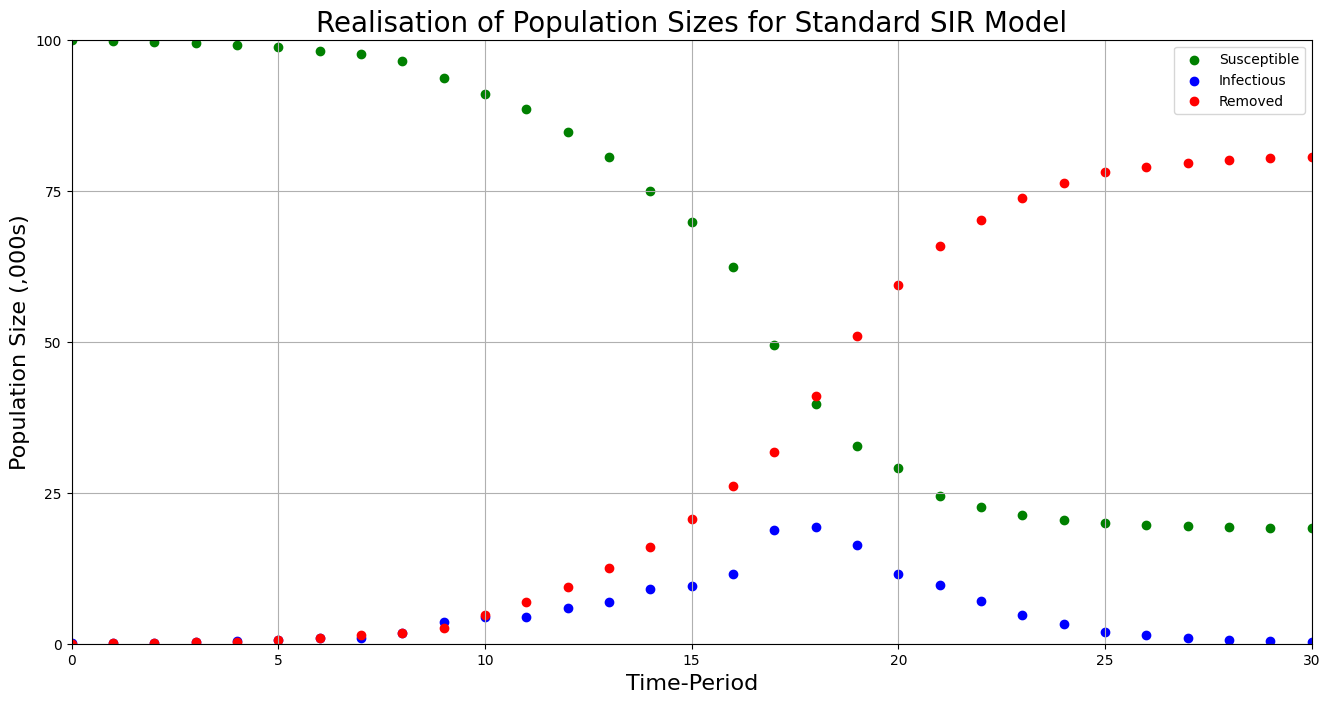

In [79]:
def sir_plot(model):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    ax.margins(0)

    xs=model.x_obs
    ys=model.observe()

    y_min=0,
    y_max=models[0].population_size

    # S
    i=0
    y_obs=[y[i] for y in ys]
    ax.scatter(xs,y_obs,c="green",label="Susceptible")

    # I
    i=1
    y_obs=[y[i] for y in ys]
    ax.scatter(xs,y_obs,c="blue",label="Infectious")

    # R
    i=2
    y_obs=[y[i] for y in ys]
    ax.scatter(xs,y_obs,c="red",label="Removed")

    ax.set_title("Realisation of Population Sizes for Standard SIR Model",fontsize=20)

    ax.set_xlabel("Time-Period",fontsize=16)
    ax.set_ylabel("Population Size (,000s)",fontsize=16)

    ax.set_xticks(np.linspace(0, max(xs,key=lambda x:x[0]), 7))
    ax.set_yticks(np.linspace(0, y_max, 5))
    ax.set_yticklabels(["{:,.0f}".format(x//1000) for x in np.linspace(0, y_max, 5)])

    plt.legend()
    plt.grid()
    plt.show()
    
sir_plot(sir_model)

In [6]:
from Models import SIRModelWithDistributions

In [7]:
sir_model=SIRModelWithDistributions(params=[100000,100,stats.gamma(a=8,scale=.125),stats.beta(100,100)],n_obs=31,x_obs=[[i] for i in range(0,31)])
np.random.seed(16111998) # Fix random seed
print(sir_model)
# sir_model.plot_obs(constant_scale=True)

Population Size=100,000.0
Initially Infected=100.0
Mean Beta=1.000
Mean Gamma=0.500
R_0=2.000


In [80]:
def single_sir_plot(ax,model,labels=False):
    xs=model.x_obs
    ys=model.observe()

    y_min=0,
    y_max=models[0].population_size
    
    a=.2

    # S
    i=0
    y_obs=[y[i] for y in ys]
    if labels: ax.plot(xs,y_obs,c="green",label="Susceptible",alpha=a)
    else: ax.plot(xs,y_obs,c="green",alpha=a)

    # I
    i=1
    y_obs=[y[i] for y in ys]
    if labels: ax.plot(xs,y_obs,c="blue",label="Infectious",alpha=a)
    else: ax.plot(xs,y_obs,c="blue",alpha=a)

    # R
    i=2
    y_obs=[y[i] for y in ys]
    if labels: ax.plot(xs,y_obs,c="red",label="Removed",alpha=a)
    else: ax.plot(xs,y_obs,c="red",alpha=a)

#     ax.set_title("Realisation of Population Sizes for Standard SIR Model",fontsize=20)

    ax.set_xlabel("Time-Period",fontsize=16)
    ax.set_ylabel("Population Size (,000s)",fontsize=16)

    ax.set_xticks(np.linspace(0, max(xs,key=lambda x:x[0]), 7))
    ax.set_yticks(np.linspace(0, y_max, 5))
    ax.set_yticklabels(["{:,.0f}".format(x//1000) for x in np.linspace(0, y_max, 5)])

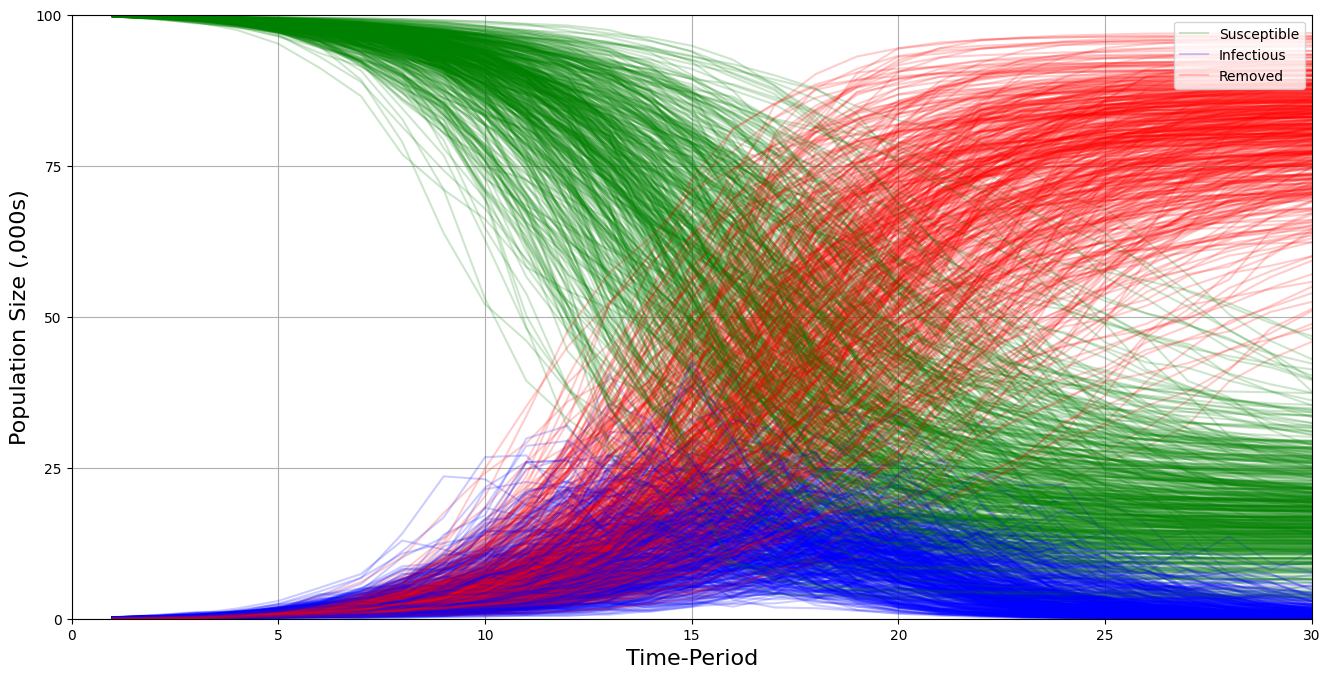

In [81]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

models=[SIRModelWithDistributions(params=[100000,100,stats.gamma(a=8,scale=.125),stats.beta(10,10)],n_obs=30,x_obs=[[i] for i in range(1,31)]) for _ in range(0,500)]

single_sir_plot(ax,models[0],labels=True)
for m in models: single_sir_plot(ax,m)

plt.legend(loc='upper right')
plt.grid()
plt.show()

In [10]:
from Models import StochasticSIRModel

In [82]:
def stochastic_sir_plot_confidence_intervals(ax,models,alpha=.05):
    # plot mean and (1-alpha) confidence interval from numerical calculation
    xs=models[0].x_obs
    
    means=[]
    upper_bounds=[]
    lower_bounds=[]
    
    for i in range(models[0].n_obs):
        y_is=[model.observe()[i] for model in models]

        mean=np.mean(y_is,axis=0)
        ub=np.percentile(y_is,100*(1-alpha/2),axis=0)
        lb=np.percentile(y_is,100*(alpha/2),axis=0)

        means+=[mean]
        upper_bounds+=[ub]
        lower_bounds+=[lb]
    
    y_min=0,
    y_max=models[0].population_size
    
    # S
    i=0
    ax.plot(xs,[m[i] for m in means],c="green",label="Susceptible")
    ax.fill_between([x[0] for x in xs],[l[i] for l in lower_bounds],[u[i] for u in upper_bounds]
                    ,color="green",alpha=.2)
    
    i=1
    ax.plot(xs,[m[i] for m in means],c="blue",label="Infectious")
    ax.fill_between([x[0] for x in xs],[l[i] for l in lower_bounds],[u[i] for u in upper_bounds]
                    ,color="blue",alpha=.2)
    
    i=2
    ax.plot(xs,[m[i] for m in means],c="red",label="Removed")
    ax.fill_between([x[0] for x in xs],[l[i] for l in lower_bounds],[u[i] for u in upper_bounds]
                    ,color="red",alpha=.2)
        
    ax.set_title("95% Confidence Intervals for Population Sizes of Stochastic SIR Model",fontsize=20)

    ax.set_xlabel("Time-Period",fontsize=16)
    ax.set_ylabel("Population Size (,000s)",fontsize=16)

    ax.set_xticks(np.linspace(0, max(xs,key=lambda x:x[0]), 7))
    ax.set_yticks(np.linspace(0, y_max, 5))
    ax.set_yticklabels(["{:,.0f}".format(x//1000) for x in np.linspace(0, y_max, 5)])

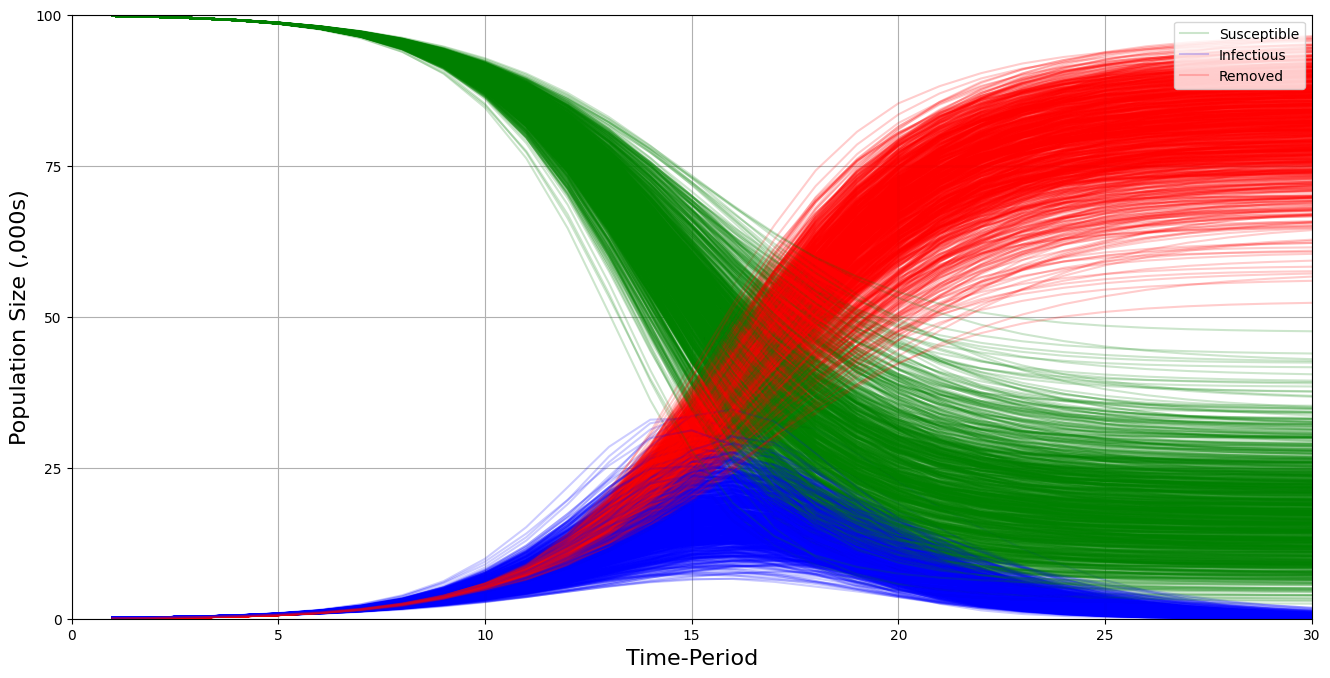

In [83]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

models=[StochasticSIRModel(params=[100000,100,1,.5,.1],n_obs=30,x_obs=[[i] for i in range(1,31)]) for _ in range(0,1000)]

single_sir_plot(ax,models[0],labels=True)
for m in models: single_sir_plot(ax,m)

plt.legend(loc='upper right')
plt.grid()
plt.show()

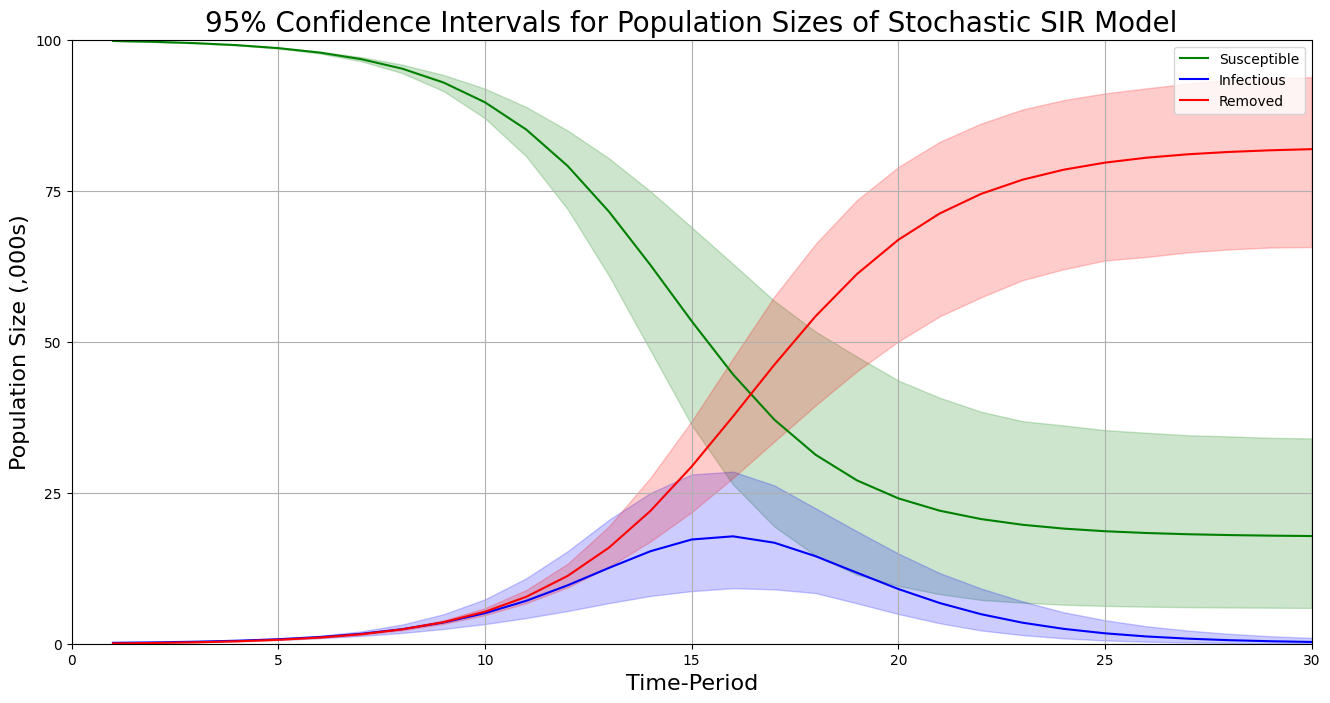

In [84]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

stochastic_sir_plot_confidence_intervals(ax,models)

plt.legend(loc='upper right')
plt.grid()
plt.show()

In [1]:
def plot_accepted_sir_observations(ax:plt.Axes,x_obs:int,y_obs:[[float]],accepted_params:[[float]],predicted_model:Model) -> plt.Axes:
    
    accepted_observations=[predicted_model.copy(params).observe() for params in accepted_params]
    
    y_min=0
    y_max=predicted_model.population_size
    
    # plot acceped
    for obs in accepted_observations:
        s_obs=[y[0] for y in obs]
        i_obs=[y[1] for y in obs]
        r_obs=[y[2] for y in obs]
        
        ax.scatter(x_obs,s_obs,c="green",alpha=.5,marker="x")
        ax.scatter(x_obs,i_obs,c="blue",alpha=.5,marker="x")
        ax.scatter(x_obs,r_obs,c="red",alpha=.5,marker="x")

    # plot observed
    ax.plot(x_obs,[y[0] for y in y_obs],c="green") # label="Observed S"
    ax.plot(x_obs,[y[1] for y in y_obs],c="blue") # label="Observed I"
    ax.plot(x_obs,[y[2] for y in y_obs],c="red") # label="Observed R"
    
    # plot predicition
    y_pred=predicted_model.observe()
    ax.plot(x_obs,[y[0] for y in y_pred],c="green",ls="--") # label="Observed S"
    ax.plot(x_obs,[y[1] for y in y_pred],c="blue",ls="--") # label="Observed I"
    ax.plot(x_obs,[y[2] for y in y_pred],c="red",ls="--") # label="Observed R"

    # make legend
    f = lambda m,l,c: ax.plot([],[], marker=m,color=c,ls=l)[0]
    handles = [f("s","",c) for c in ["green","blue","red"]]
    handles+=[f("x","","black")]
    handles+= [f(None,l,"black") for l in ["-","--"]]

    ax.legend(handles=handles,labels=["S","I","R","Accepted","Observed","Predicted"],loc="upper left",ncol=2)
    
    ax.set_xlabel("Day",fontsize=16)
    ax.set_ylabel("Population Size (,000s)",fontsize=16)

    ax.set_xticks(list(range(0,max(x_obs,key=lambda x:x[0])[0],5))+[29])
    ax.set_yticks(np.linspace(0, y_max, 5))
    ax.set_yticklabels(["{:,.0f}".format(x//1000) for x in np.linspace(0, y_max, 5)])
    
    ax.margins(0)

    return ax


NameError: name 'plt' is not defined

In [17]:
def plot_parameter_posteriors(parameter_names:[str],accepted_parameters:[[float]],predicted_vals:[float],priors:["stats.Distribution"],weights=None) -> plt.Figure:
    fig=plt.Figure()

    weights = weights if (weights) else [1/len(accepted_parameters) for _ in range(len(accepted_parameters))]
    
    acc_params_x=[p[0] for p in accepted_parameters]
    acc_params_y=[p[1] for p in accepted_parameters]
    
    fig = plt.figure()
    gs = GridSpec(4, 4)

    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0,0:3])
    ax_hist_y = fig.add_subplot(gs[1:4, 3])

    # plot scatter
    sns.kdeplot(acc_params_x,acc_params_y,cmap="Blues", shade=True,weights=weights,ax=ax_scatter)
    
    # plot accepted data
    ax_hist_x.hist(acc_params_x,density=True)
    ax_hist_y.hist(acc_params_y,orientation='horizontal',density=True)

    # plot priors used
    hist_x_xs=np.linspace(min(acc_params_x+[priors[0].ppf(.01)-.25]),max(acc_params_x+[priors[0].ppf(.99)+.25]),100)
    ax_hist_x.plot(hist_x_xs,priors[0].pdf(hist_x_xs),"k-",lw=2, label='Prior')
    hist_y_xs=np.linspace(min(acc_params_y+[priors[1].ppf(.01)-.25]),max(acc_params_y+[priors[1].ppf(.99)+.25]),100)
    ax_hist_y.plot(priors[1].pdf(hist_y_xs),hist_y_xs,"k-",lw=2, label='Prior')
    
    # plot smooth posterior (ie KDE)
    density_x=stats.kde.gaussian_kde(acc_params_x,weights=weights)
    ax_hist_x.plot(hist_x_xs,density_x(hist_x_xs),"--",lw=2,c="orange",label="Posterior KDE")
    density_y=stats.kde.gaussian_kde(acc_params_y,weights=weights)
    ax_hist_y.plot(density_y(hist_y_xs),hist_y_xs,"--",lw=2,c="orange",label="Posterior KDE")
        
    # plot posterior mean
    ax_hist_x.vlines(predicted_vals[0],ymin=0,ymax=ax_hist_x.get_ylim()[1],colors="orange")
    ax_hist_y.hlines(predicted_vals[1],xmin=0,xmax=ax_hist_y.get_xlim()[1],colors="orange")
    
    # make legend
    f = lambda m,l,c: ax_scatter.plot([],[], marker=m,color=c,ls=l)[0]
    handles=[f(None,"-","black"),f(None,"-","orange"),f(None,"--","orange"),f("s","","#1f77b4")]

#     ax_scatter.legend(handles=handles,labels=["Prior","Posterior Mean","Posterior KDE","Accepted"],fontsize=18)
    ax_scatter.set_xlim((hist_x_xs[0],hist_x_xs[-1]))
    ax_scatter.set_ylim((hist_y_xs[0],hist_y_xs[-1]))

    ax_scatter.set_xlabel(parameter_names[0])
    ax_scatter.set_ylabel(parameter_names[1])
    
    ax_scatter.margins(0)
    ax_hist_x.margins(0)
    ax_hist_y.margins(0)
    
    return fig


### Basic Reproduction Number $R_0$
The basic reproduction number in empidemiology is the expected number of new cases to generate from each infection, assuming all individuals are susceptible to the disease. This value is "easily" interpretable as $R_0>1$ means the epidemic is spreading and $R_0<1$ means the epidemic is receeding. For this reason, estimates of $R_0$ has been used as a headline statistic during the Rona pandemic and likely motivated government policy.

For the SIR model, $R_0$ is defined as
$$ R_0:=\frac\beta{\gamma+\delta} $$
where $\beta,\gamma$ are as above and $\delta$ is the natural death-rate in the population (Assumed to be 0 in the classical SIR model used throught this notebook).

Below I define a function `estimate_r0` which produces a confidence interval (default=90%) for the $R_0$ value using the accepted set of parameter values.

In [12]:
def estimate_r0(accepted_params,weights=None,interval_width=.9):
    if (interval_width<=0) or (interval_width>=1): raise ValueError("`interval_width` must be in (0,1)")
    
    weights=weights if (weights) else [1/len(accepted_params) for _ in range(len(accepted_params))]
    
    r0s=[]
    for _ in range(1000):
        ind=np.random.choice(len(accepted_params),size=1,p=weights)
        params=accepted_params[ind[0]]
        r0s.append(params[2]/params[3])
    
    lower_bound=(1-interval_width)/2
    upper_bound=1-lower_bound
    
    return np.quantile(r0s,lower_bound),np.quantile(r0s,upper_bound)

## SIR and ABC

### Implementation <a id="SIR-and-ABC-Implementation"></a>
Here I run all three of the ABC algorithms which were discussed in [ABC_Notebook](ABC_Notebook.ipynb) on the classical SIR model described [above](#sir_model_specified) (ABC-Rejection Sampling, ABC-MCMC and ABC-SMC).

For all three algorithms I use the same set of priors and summary statistics:
 * For total population size $N$ and the intial number of infectious people $I(0)$ I set the priors st the true value is always returned as it is reasonable for these values to be known to a high degree of accuracy in real-world scenarios.
 * For $\beta,\gamma$ I defined the priors below. These priors where chosen as their means are not the true values so the parameters so some learning needs to occur for a good fit to occur. I had to make the priors fairly narrow to avoid overflow errors in my implementation.
 $$ \pi_0(\beta)\sim\mathcal{U}[0,1.5]\quad\pi_0(\gamma)\sim\mathcal{U}[0,2] $$
 * For the summary statistics I naively use the identity function. In practice this means that each time-point of the simualted time-series is compared to the equivalent time-point in the observed time-series. 

**ABC-Rejection Sampling**
 * The *Best Samples* variation is used. This reduces the amount of tuning which needs to be done.
 * Ran 10,000 simulations and then use the best 100 to fit the model.

**ABC-MCMC**
 * The perturbance kernels adds additive gaussian noise with mean $0$ and variance $\sigma^2=.1$ to $\beta,\gamma$. No change occurs to $N$ or $I(0)$ as their true values are provided to the algorithm. I chose $\sigma^2$ completely arbitraly.
 * A gaussian acceptance kernel is used with bandwidth $\varepsilon=20,000$. I tweaked this value until ~5% of all perturbances were accepted.
 
**ABC-SMC**
 * The same perturbance kernel is used as in ABC-MCMC.
 * A sequence of 3 bandwidths are used, equally spaced from 50,000 to 15,000.
 * A sample size of 25 is used.
 * The bandwidths and sample size were chosen st the run-time of this algorithm was similar to the other two.
 * Due to technical reasons around how `scipy.stats.uniform.pdf` is implemented, I have to define proper priors for population size $N$ and number of initial infectees $I(0)$ in order to avoid null values which cause problems when calculating the weight for each sample point (without having to do a significant rework to my implementation). As I have defined these priors to be extremely narrow, this results in no practical changes to the performance of the algorithm.
 
*I comment on the performance of each algorithm after they are run.*

### ABC-Rejection Algorithm

In [13]:
%%time
# ABC-Rejection Sampling (Best Samples)
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"best","num_runs":5000,"sample_size":50,"distance_measure":ABC.log_l2_norm}
fitted_model_rej,accepted_params_rej=ABC.abc_rejcection(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,sampling_details=sampling_details,show_plots=False)
print("True Model - {}\n".format(sir_model))
print("Fitted Model - {}\n".format(fitted_model_rej))

# 90% CI for R0 value
r0_estimate_rej=estimate_r0(accepted_params_rej)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_rej[0],r0_estimate_rej[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_rej.observe(),sir_model.observe(),ln=True)))

True Model - Population Size=100,000.0           
Initially Infected=100.0
Beta=1.000
Gamma=0.500
R_0=2.000

Fitted Model - Population Size=100,000.0
Initially Infected=100.0
Beta=0.970
Gamma=0.492
R_0=1.972

R0 - [1.763,2.481]
RSSE: 3,721.928
Wall time: 4.18 s


In [68]:
# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_rej],alpha=.05,weights=None)
gamma_ci=ci_parameters([p[3] for p in accepted_params_rej],alpha=.05,weights=None)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Beta - [0.133,1.098]
Gamma - [0.000,0.621]


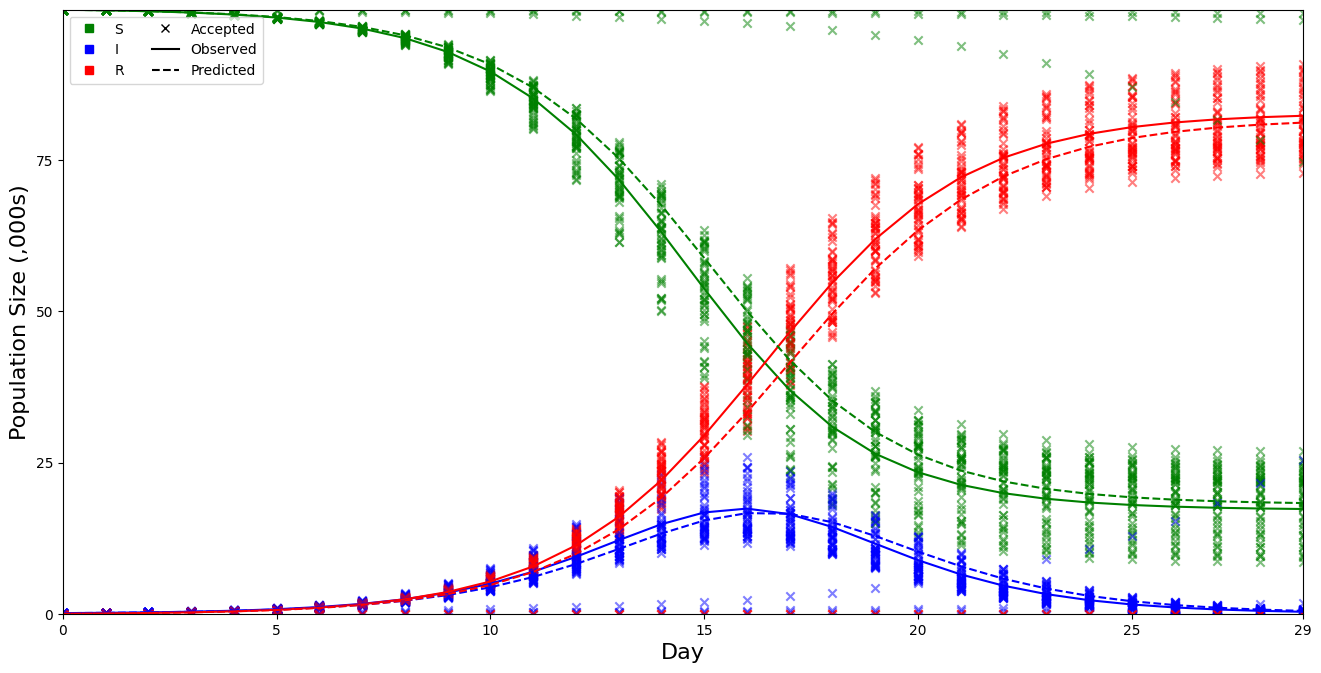

In [81]:
fig=plt.Figure()
ax=fig.add_subplot(1,1,1)

ax=plot_accepted_sir_observations(ax,x_obs=sir_model.x_obs,y_obs=sir_model.observe(),accepted_params=accepted_params_rej,predicted_model=fitted_model_rej)

fig

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


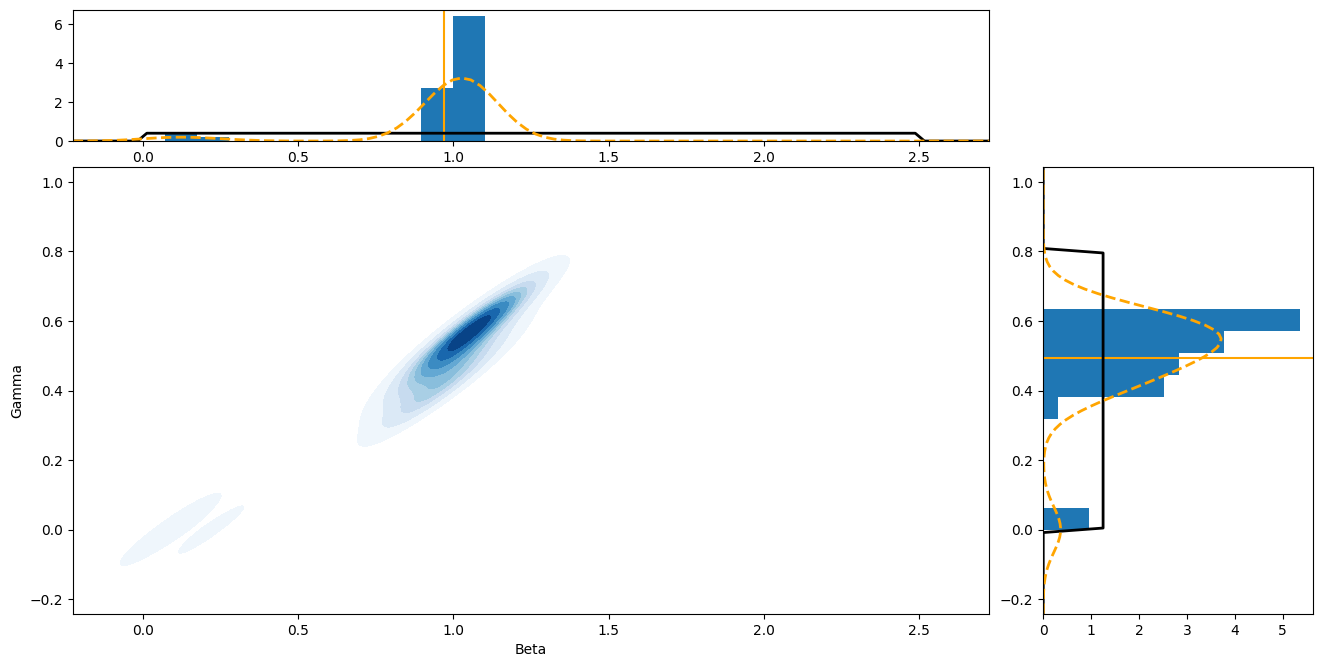

In [74]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_rej],predicted_vals=fitted_model_rej.params[2:],priors=sir_priors[2:],weights=None)

In [ ]:
fig=plt.Figure()
ax=fig.add_subplot(1,1,1)

heatmap, xedges, yedges = np.histogram2d([p[2] for p in accepted_params_rej],[p[3] for p in accepted_params_rej],bins=50,density=True,weights=None,range=[[0,2.5],[0,.8]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

heatmap_img=ax.imshow(heatmap.T, extent=extent, origin='lower')
fig.colorbar(heatmap_img)
ax.set_xlim((0,2.5))
ax.set_ylim((0,.8))
fig

*Comments*

The fitted model has parameter values $\hat\beta=0.954$ and $\hat\gamma=0.364$. This shows a very good fit for $\beta$ but less good for $\gamma$. This is overall a good fit, especially since it took less than 10 seconds. A better fit could likely be achieved without requiring greater computational resources by fiddling with the algorithm parameters (Namely number of simualtions and proportion accepted).

Observing the plots of accepted simulated values (RHS) it is interesting how the plots for the susceptible (dim=0) and infected (dim=1) populations have a significant number of accepted simulations which are very close to the observed values but also a large number which deviate significantly (but all in a similar way). This would suggest that either increasing the number of simulations being run or decreasing the proportion of simulations being used to fit the model would very quickly improve the model fit.

It is notable that the plot the removed population (dim=2) does not show this property, likely suggesting that small changes in $\beta$ have a greater affect on the model than small changes in $\gamma$. This is worth exploring further.

The posteriors for $\beta,\gamma$ ($\theta_2,\theta_3$ respectively) do show that a significant amount of mass is placed near the true values of each parameter, showing that significant learning has occured.

### ABC-MCMC

Found Start - (20) [100000.0, 100.0, 0.9977052564852246, 0.445370903443006]
0.335 observations were new.


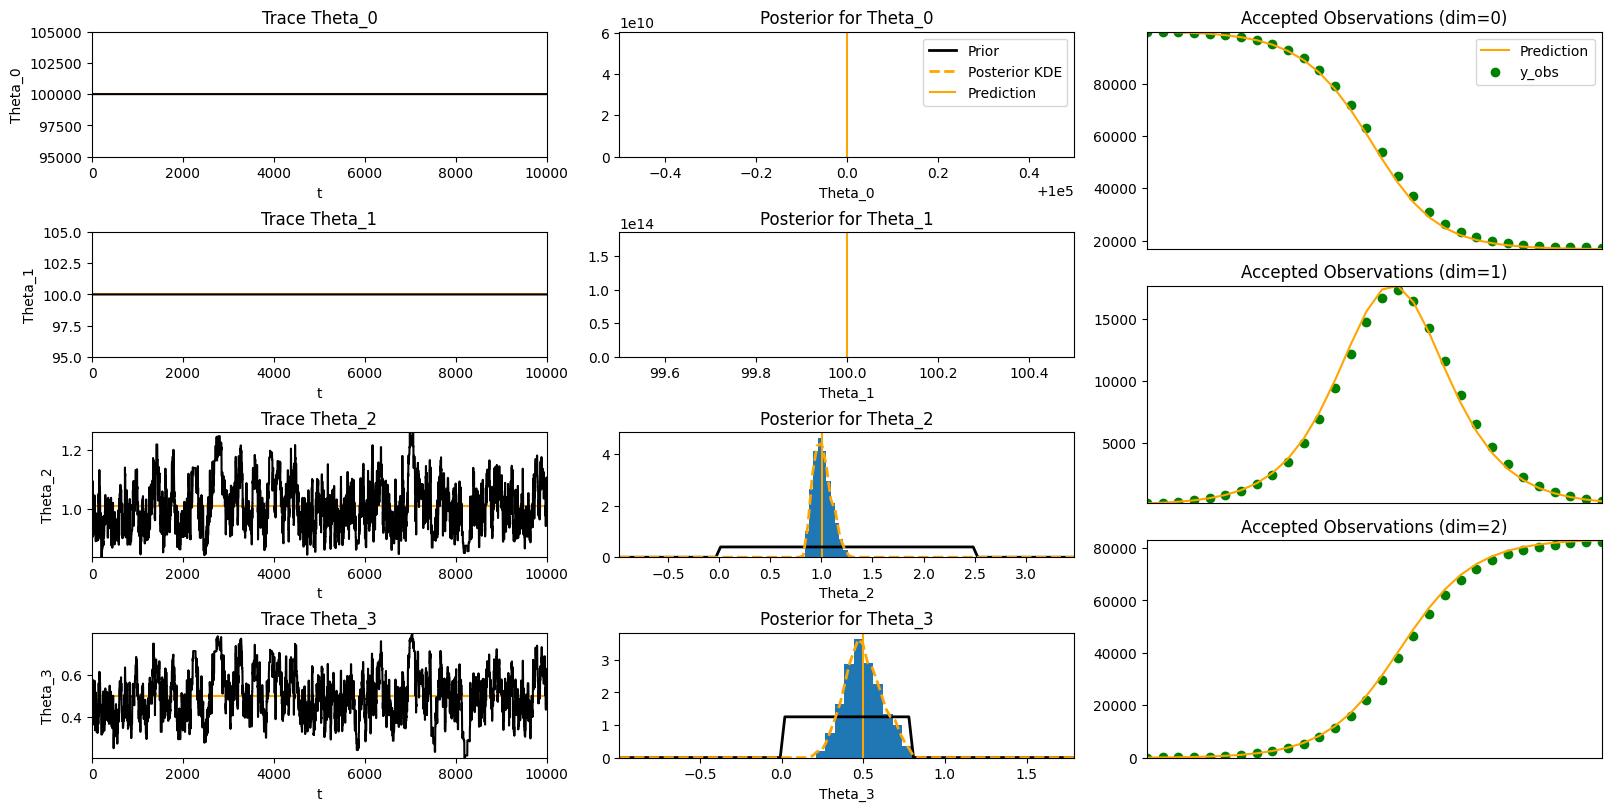

True Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
R_0=2.000

Fitted Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.011
Gamma=0.501
R_0=2.019

R0 - [1.612,2.927]
RSSE: 3,021.836
Wall time: 37.3 s


In [27]:
%%time
# ABC-MCMC
np.random.seed(16111998) # Fix random seed
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,.05).rvs(1)[0]]*2

fitted_model_mcmc,accepted_params_mcmc=ABC.abc_mcmc(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,
    chain_length=10000,perturbance_kernels=perturbance_kernels,acceptance_kernel=ABC.gaussian_kernel,scaling_factor=10**(-.3),distance_measure=ABC.log_l2_norm)

print("True Model - {}\n".format(sir_model))
print("Fitted Model - {}\n".format(fitted_model_mcmc))

# 90% CI for R0 value
r0_estimate_mcmc=estimate_r0(accepted_params_mcmc)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_mcmc[0],r0_estimate_mcmc[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_mcmc.observe(),sir_model.observe(),ln=True)))

In [69]:
beta_ci=ci_parameters([p[2] for p in accepted_params_mcmc],alpha=.05,weights=None)
gamma_ci=ci_parameters([p[3] for p in accepted_params_mcmc],alpha=.05,weights=None)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Beta - [0.871,1.194]
Gamma - [0.290,0.736]


c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


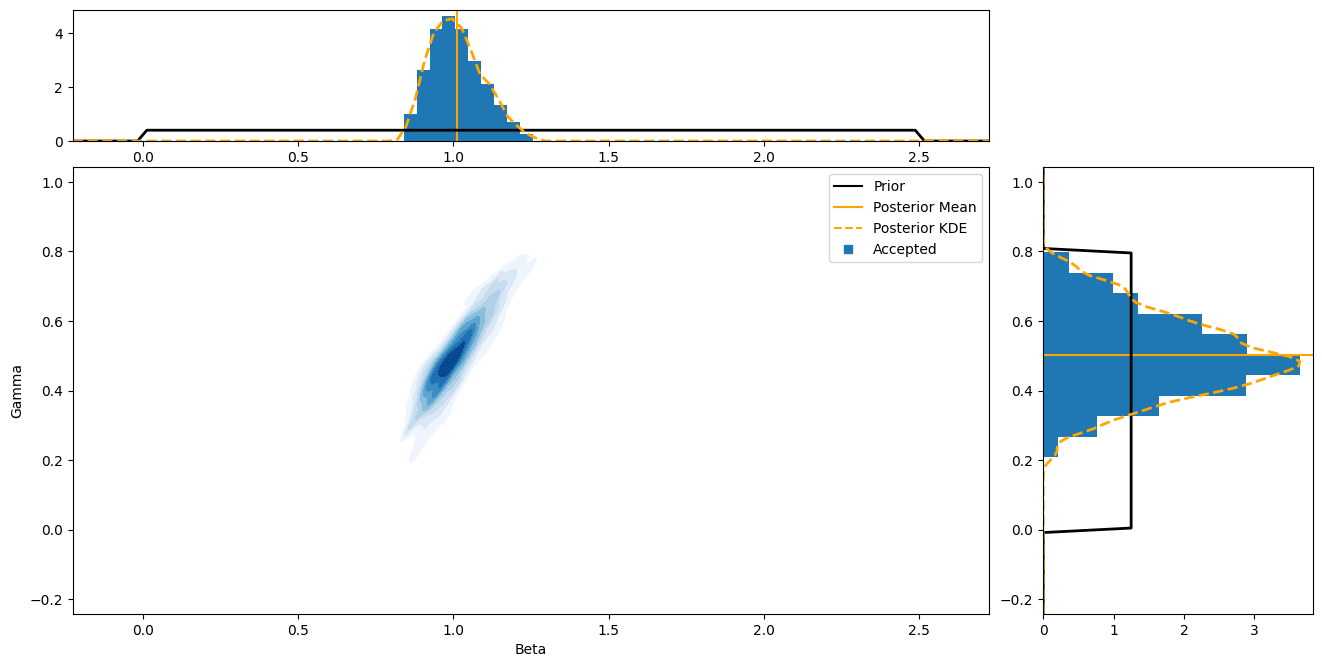

In [57]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_mcmc],predicted_vals=fitted_model_mcmc.params[2:],priors=sir_priors[2:],weights=None)

*Comments*

I tuned the bandwidth st ~30% of simulations were accepted.

The fitted model has parameter values $\hat\beta=0.961$ and $\hat\gamma=0.393$. This is an almost perfect fit for $\beta$ but not so good for $\gamma$. The resulting fit is very similar to that from ABC-Rejection sampling. The initial burn-in took 13 simulations and of the 10,000 perturbances in the MCMC-step 31.1% were accepted.

For this model, the performance of ABC-MCMC is very similar to that of ABC-Rejection Sampling. However the MCMC method took ~5 times as long to run (7s vs 35s) despite performing a very similar number of simulations (10,000 vs 10,013).

Again, the posteriors (middle col.) have their mass concentrated close to the true value of each parameter and are significantly different shapes than the priors, showing that significant learning has occurred.

### ABC-SMC

(105) - 100/100
(1/20 - 110) - 99/100 (eps=0.013)
(2/20 - 108) - 99/100 (eps=0.016)
(3/20 - 110) - 99/100 (eps=0.020)
(4/20 - 115) - 99/100 (eps=0.025)
(5/20 - 123) - 99/100 (eps=0.032)
(6/20 - 127) - 99/100 (eps=0.040)
(7/20 - 137) - 99/100 (eps=0.050)
(8/20 - 132) - 99/100 (eps=0.063)
(9/20 - 175) - 99/100 (eps=0.079)
(10/20 - 202) - 99/100 (eps=0.100)
(11/20 - 202) - 99/100 (eps=0.126)
(12/20 - 194) - 99/100 (eps=0.158)
(13/20 - 258) - 99/100 (eps=0.200)
(14/20 - 278) - 99/100 (eps=0.251)
(15/20 - 378) - 99/100 (eps=0.316)
(16/20 - 382) - 99/100 (eps=0.398)
(17/20 - 549) - 99/100 (eps=0.501)
(18/20 - 736) - 99/100 (eps=0.631)
(19/20 - 907) - 99/100 (eps=0.794)

Total Simulations - 5,328
theta_hat - [100000.04304897158, 100.05180160009384, 1.0133701638301245, 0.5173477080461956]


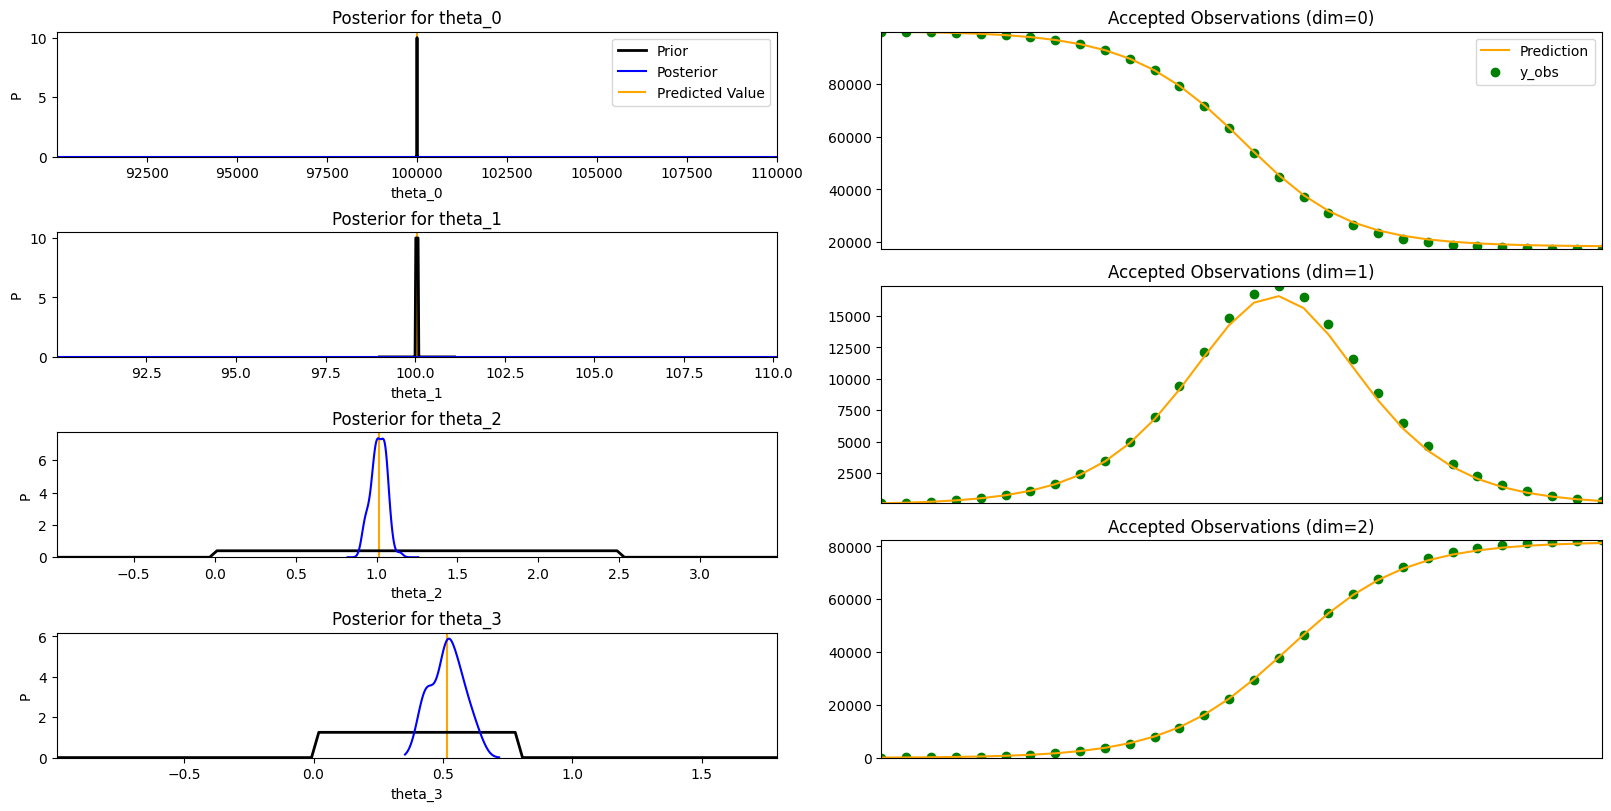

True Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
R_0=2.000

Fitted Model - Population Size=100,000.0
Initially Infected=100.1
Beta=1.013
Gamma=0.517
R_0=1.959

R0 - [1.723,2.318]
RSSE: 2,393.699
Wall time: 5min 42s


In [29]:
%%time
# ABC-SMC
np.random.seed(16111998) # Fix random see
scaling_factors=list(np.logspace(-2,-.1,20,base=10))

perturbance_variance=.1
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,perturbance_variance).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:1]*2 + [lambda x,y:stats.norm(0,perturbance_variance).pdf(x-y)]*2

fitted_model_smc,accepted_params_smc,weights_smc=ABC.abc_smc(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_smc_priors,
    num_steps=20,sample_size=100,scaling_factors=scaling_factors,perturbance_kernels=perturbance_kernels,
    perturbance_kernel_probability=perturbance_kernel_probability,acceptance_kernel=ABC.gaussian_kernel,distance_measure=ABC.log_l2_norm)

print("True Model - {}\n".format(sir_model))
print("Fitted Model - {}\n".format(fitted_model_smc))

# 90% CI for R0 value
r0_estimate_smc=estimate_r0(accepted_params_smc,weights=weights_smc)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_smc[0],r0_estimate_smc[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_smc.observe(),sir_model.observe(),ln=True)))

In [71]:
beta_ci=ci_parameters([p[2] for p in accepted_params_smc],alpha=.05,weights=None)
gamma_ci=ci_parameters([p[3] for p in accepted_params_smc],alpha=.05,weights=None)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Beta - [0.921,1.089]
Gamma - [0.411,0.632]


c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


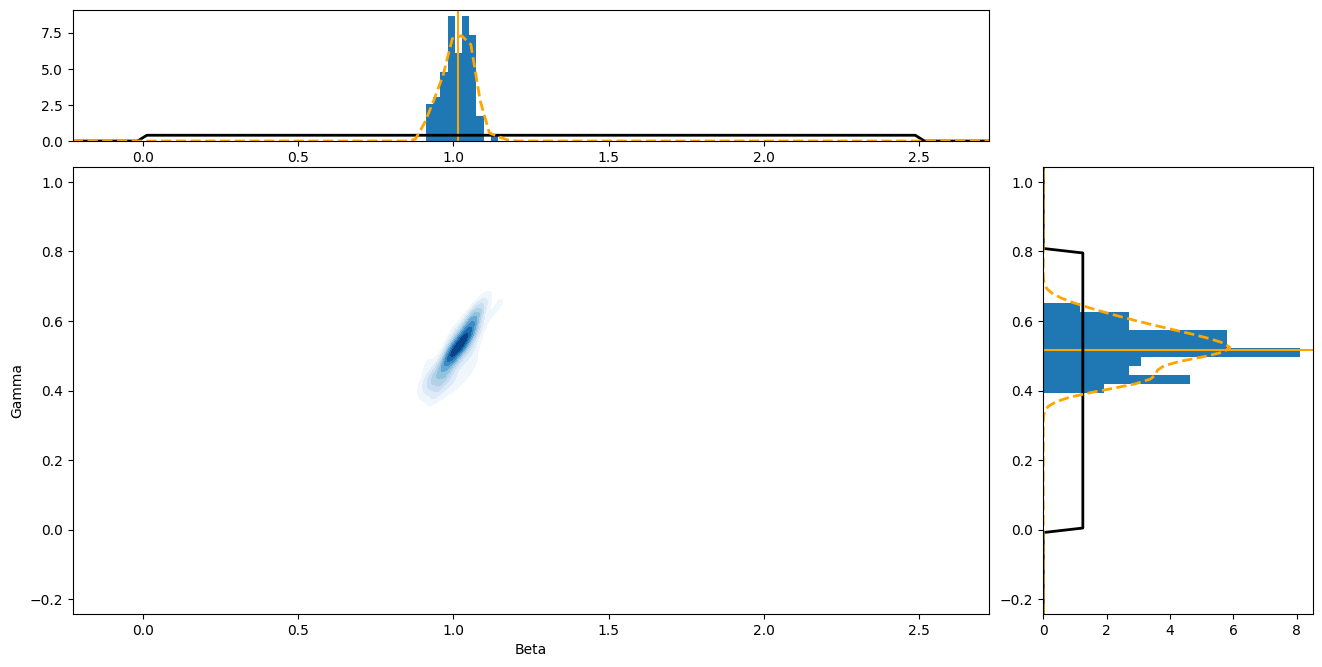

In [75]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_smc],predicted_vals=fitted_model_smc.params[2:],priors=sir_priors[2:],weights=weights_smc)

*Comments*

The fitted model has parameter values $\hat\beta=1.000$ and $\hat\gamma=0.484$. This is an almost perfect fit and significantly better than the other two algorithms. The initial sample took 2,035 simulations and a total of 4,307 simulations were performed.

The final fit is practically perfect and this algorithm ran significantly faster than ABC-MCMC (but slower than ABC-Rejection Sampling). This suggests that ABC-SMC is best suited to fitting classical SIR models, but this may not be true after tuning and summary statistic choice.

As with the other two algorithms, the posteriors (LHS) have their mass concentrated close to the true value of each parameter and are significantly different shapes than the priors, showing that significant learning has occurred.

### Adaptive ABC-SMC

(100) - 100/100
Total Sims = 100 < 5,000

Perturbance Variances=[0.00069842 0.00082157 0.44933024 0.05818162]                       
(0/100 - 117) - 99/100 (eps=69.805>0.000)
Total Sims = 217 < 5,000

Perturbance Variances=[0.00083862 0.00078575 0.34274096 0.03776647]                       
(1/100 - 109) - 99/100 (eps=34.108>0.000)
Total Sims = 326 < 5,000

Perturbance Variances=[0.00079324 0.00080426 0.31329515 0.04067952]                       
(2/100 - 112) - 99/100 (eps=26.171>0.000)
Total Sims = 438 < 5,000

Perturbance Variances=[0.00086915 0.00071467 0.2701463  0.03296139]                       
(3/100 - 110) - 99/100 (eps=24.639>0.000)
Total Sims = 548 < 5,000

Perturbance Variances=[0.00075596 0.00084258 0.23742988 0.03181717]                       
(4/100 - 111) - 99/100 (eps=23.658>0.000)
Total Sims = 659 < 5,000

Perturbance Variances=[0.00079936 0.00064152 0.20817428 0.03527996]                       
(5/100 - 112) - 99/100 (eps=22.525>0.000)
Total Sims = 771 < 5,000

Pert

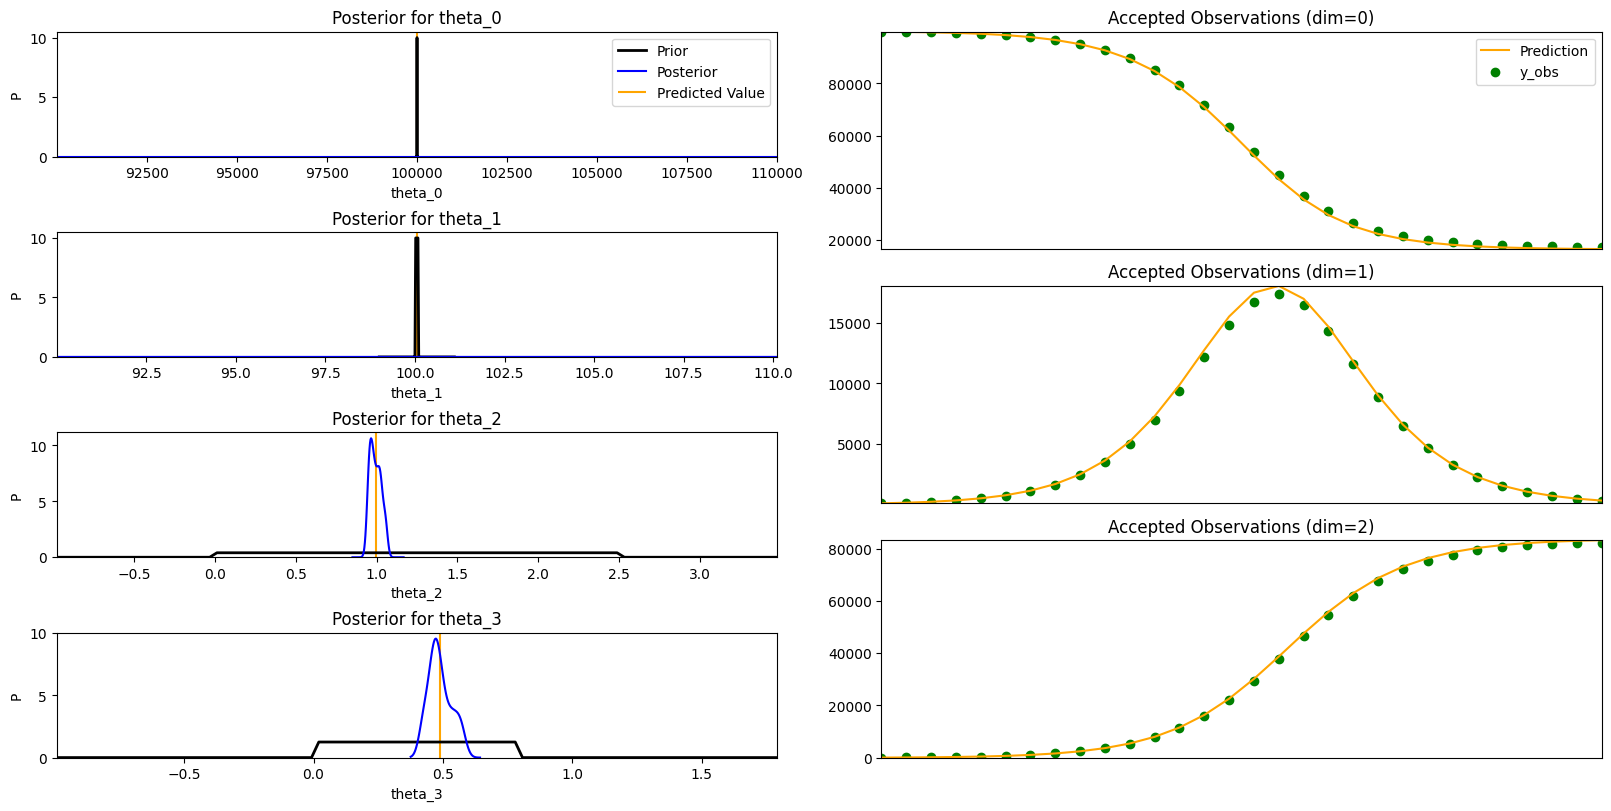

True Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
R_0=2.000

Fitted Model - Population Size=100,000.0
Initially Infected=100.1
Beta=0.994
Gamma=0.489
R_0=2.034

R0 - [1.852,2.235]
RSSE: 2,563.218
Wall time: 24min 11s


In [9]:
%%time
# ABC-SMC
np.random.seed(16111998) # Fix random seed

fitted_model_adapt_smc,accepted_params_adapt_smc,weights_adapt_smc=ABC.adaptive_abc_smc(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_smc_priors,
    max_steps=100,sample_size=100,max_simulations=5000,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,distance_measure=ABC.log_l2_norm)

print("True Model - {}\n".format(sir_model))
print("Fitted Model - {}\n".format(fitted_model_adapt_smc))

# 90% CI for R0 value
r0_estimate_adapt_smc=estimate_r0(accepted_params_adapt_smc,weights=weights_adapt_smc)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_adapt_smc[0],r0_estimate_adapt_smc[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_adapt_smc.observe(),sir_model.observe(),ln=True)))

In [72]:
beta_ci=ci_parameters([p[2] for p in accepted_params_adapt_smc],alpha=.05,weights=None)
gamma_ci=ci_parameters([p[3] for p in accepted_params_adapt_smc],alpha=.05,weights=None)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Beta - [0.947,1.057]
Gamma - [0.422,0.572]


c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


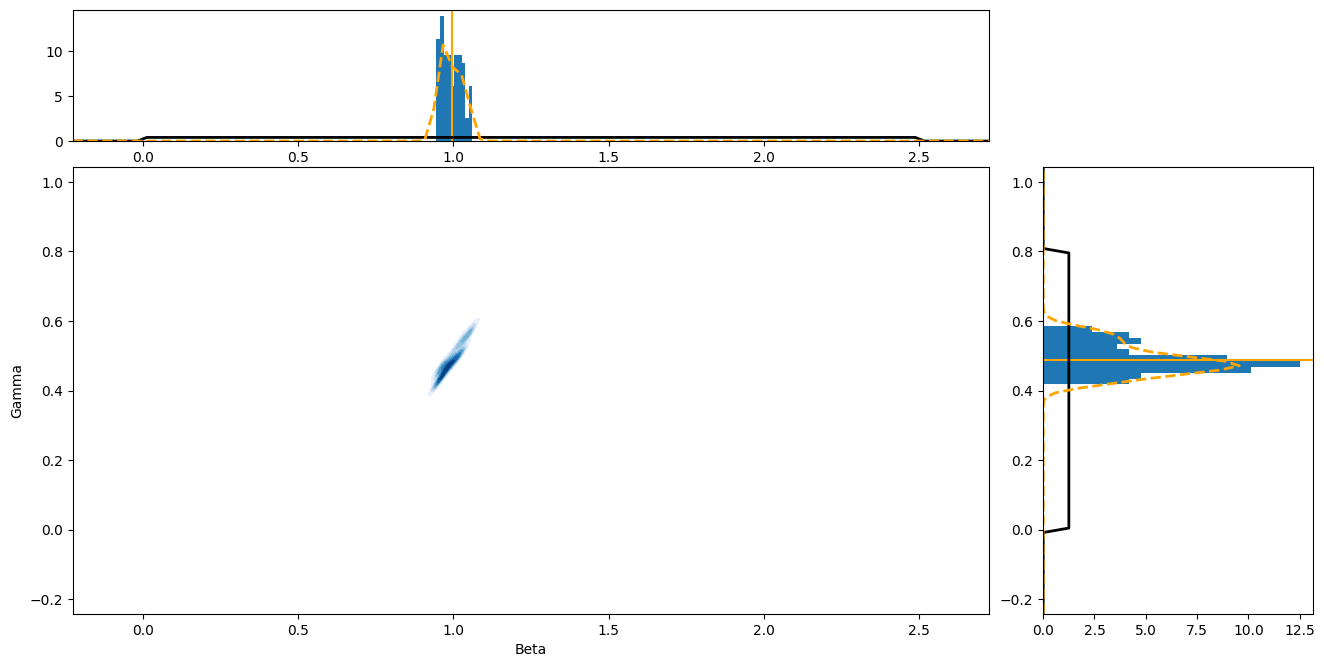

In [76]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_adapt_smc],predicted_vals=fitted_model_adapt_smc.params[2:],priors=sir_priors[2:],weights=weights_adapt_smc)

*Comments*


### Better Summary Statistics

<a id="better_ss_peaks"></a>
**Peaks**

In *Approximate Bayesian Computation for infectious disease modelling* Minter and Retkute suggest three sets of summary statistics
<ol>
    <li>Identity function (As I used <a href="#Implementation">above</a>).</li>
    <li> $\{R(29)\}$ - The size of the removed population on the final day.</li>
    <li> $\{I(16),R(29)\}$ - The size of the infectious and removed populations on the days of their respective peaks in the observed data.</li>
</ol>

Below I implement and use sets 2. and 3. with the ABC-SMC algorithm. In both cases I tuned the set of bandwidths st ~5,000 total simulations occur of which ~2,000 are in the intial serach period, all other parameters are the same as [above](#ABC-SMC). I have does this so that the results are comparable with the implementation of ABC-SMC which uses the identity function as its summary statistic [above](#ABC-SMC).

In [9]:
# Define the summary stats
removed_peak_ss=(lambda ys:[ys[29][2]])
infected_peak_ss=(lambda ys:[ys[16][1]])

<a id="better_ss_1"></a>

(100) - 100/100
Total Sims = 100 < 4,500

Perturbance Variances=[0.06984171 0.08215668 0.16175889 0.36363511]                       
(0/100 - 111) - 99/100 (eps=82,243.000>0.000)
Total Sims = 211 < 4,500

Perturbance Variances=[0.07856401 0.07500177 0.11624546 0.28924112]                       
(1/100 - 121) - 99/100 (eps=82,204.000>0.000)
Total Sims = 332 < 4,500

Perturbance Variances=[0.07622838 0.08859336 0.10188116 0.26402301]                       
(2/100 - 115) - 99/100 (eps=82,175.000>0.000)
Total Sims = 447 < 4,500

Perturbance Variances=[0.07399433 0.07845021 0.12818473 0.30754425]                       
(3/100 - 140) - 99/100 (eps=82,140.000>0.000)
Total Sims = 587 < 4,500

Perturbance Variances=[0.07880308 0.0803475  0.11096698 0.27767015]                       
(4/100 - 165) - 99/100 (eps=82,068.000>0.000)
Total Sims = 752 < 4,500

Perturbance Variances=[0.0706029  0.07663214 0.11082985 0.22133355]                       
(5/100 - 159) - 99/100 (eps=81,921.000>0.000)
Total 

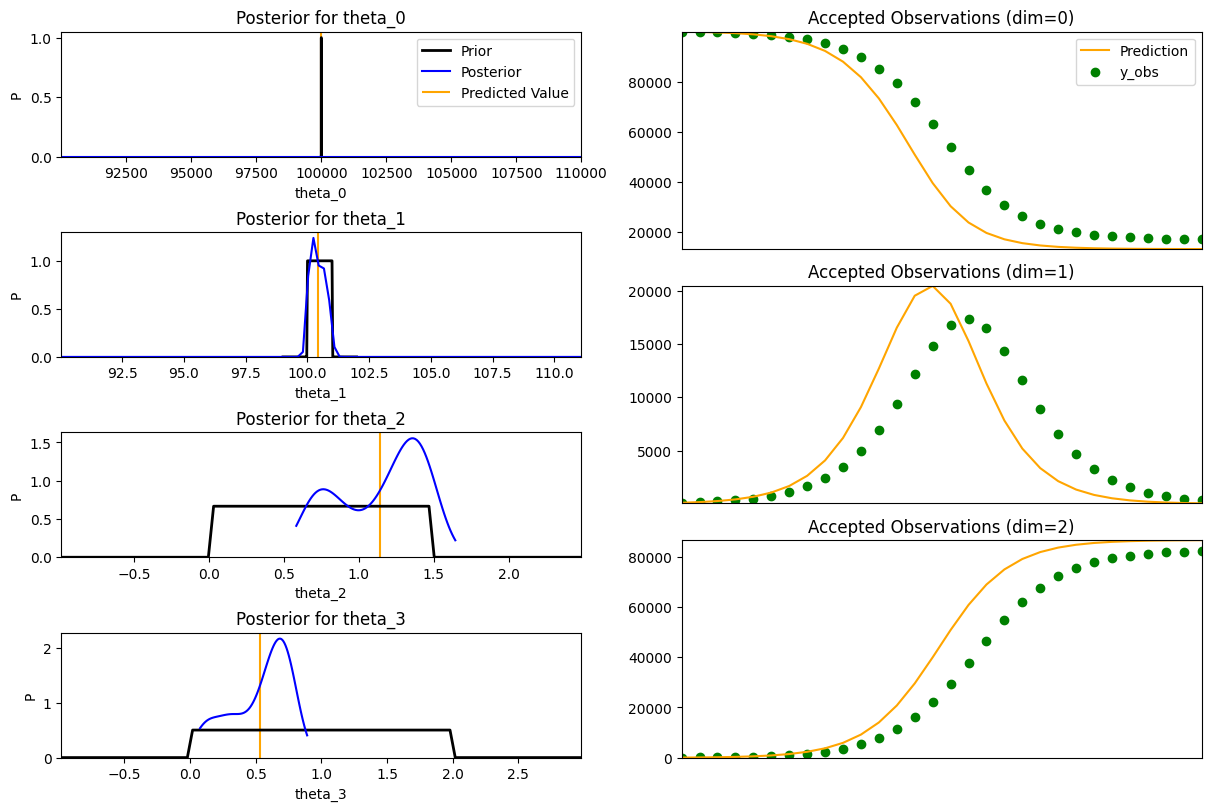

True Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
R_0=2.000

Fitted Model - Population Size=100,000.4
Initially Infected=100.4
Beta=1.138
Gamma=0.533
R_0=2.137

R0 - [2.008,2.018]
RSSE: 5,542.244
Wall time: 15min 21s


In [10]:
%%time
# Adaptive ABC-SMC \w R peak
np.random.seed(16111998) # Fix random seed

fitted_model,_=ABC.adaptive_abc_smc(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_smc_priors,
    max_steps=100,sample_size=100,max_simulations=4500,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,
    summary_stats=[removed_peak_ss])

print("True Model - {}\n".format(sir_model))
print("Fitted Model - {}\n".format(fitted_model))

# 90% CI for R0 value
r0_estimate=estimate_r0(accepted_params)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate[0],r0_estimate[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model.observe(),sir_model.observe(),ln=True)))

*Comments*



<a id="better_ss_2"></a>

(100) - 100/100
Total Sims = 100 < 4,500

Perturbance Variances=[0.06984171 0.08215668 0.16175889 0.36363511]                       
(0/100 - 114) - 99/100 (eps=99,625.163>0.000)
Total Sims = 214 < 4,500

Perturbance Variances=[0.07559747 0.07431391 0.11946654 0.27293208]                       
(1/100 - 122) - 99/100 (eps=99,587.301>0.000)
Total Sims = 336 < 4,500

Perturbance Variances=[0.06593231 0.07547908 0.09525949 0.2579209 ]                       
(2/100 - 134) - 99/100 (eps=99,545.136>0.000)
Total Sims = 470 < 4,500

Perturbance Variances=[0.07739857 0.07084578 0.10854395 0.3002708 ]                       
(3/100 - 145) - 99/100 (eps=99,480.447>0.000)
Total Sims = 615 < 4,500

Perturbance Variances=[0.06676477 0.07360363 0.08507989 0.16918989]                       
(4/100 - 130) - 99/100 (eps=99,308.706>0.000)
Total Sims = 745 < 4,500

Perturbance Variances=[0.07497079 0.06960782 0.08765379 0.13385753]                       
(5/100 - 119) - 99/100 (eps=99,083.177>0.000)
Total 

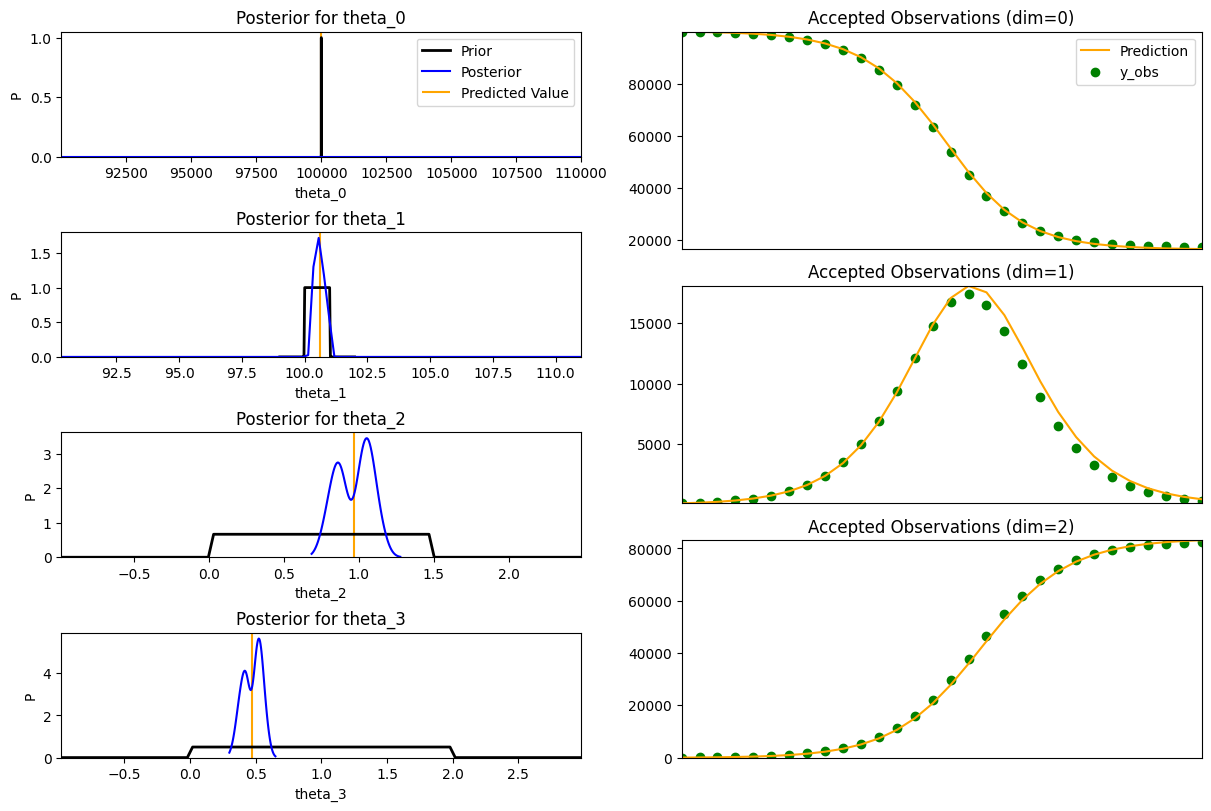

True Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
R_0=2.000

Fitted Model - Population Size=100,000.7
Initially Infected=100.6
Beta=0.969
Gamma=0.475
R_0=2.039

R0 - [2.008,2.018]
RSSE: 2,729.415
Wall time: 19min 3s


In [11]:
%%time
# ABC-SMC \w I AND R peak
np.random.seed(16111998) # Fix random seed

fitted_model,_=ABC.adaptive_abc_smc(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_smc_priors,
    max_steps=100,sample_size=100,max_simulations=4500,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,
    summary_stats=[removed_peak_ss,infected_peak_ss])

print("True Model - {}\n".format(sir_model))
print("Fitted Model - {}\n".format(fitted_model))

# 90% CI for R0 value
r0_estimate=estimate_r0(accepted_params)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate[0],r0_estimate[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model.observe(),sir_model.observe(),ln=True)))

*Comments*



<a id="better_ss_acutal_peak"></a>
**Actual Peak**

I propose the following set of summary statistics
<ol>
    <li>Date of peak of infectious population.</li>
    <li>Peak size of infectious population.</li>
</ol>
So that these statistics are approximately equally weighted I multiply 1. by 1,000 as the peak date sound be ~16 and the peak infected population ~17,500.

I tuned the set of bandwidths st ~5,000 total simulations occur of which ~2,000 are in the intial serach period, all other parameters are the same as [above](#ABC-SMC). I have does this so that the results are comparable with all previous implementations of ABC-SMC.

In [12]:
# Define summary statistics
peak_infections_date_ss=(lambda ys:[1000*ys.index(max(ys,key=lambda y:y[1]))])
peak_infections_value_ss=(lambda ys:[max(ys,key=lambda y:y[1])[1]])

(100) - 100/100
Total Sims = 100 < 4,500

Perturbance Variances=[0.06984171 0.08215668 0.16175889 0.36363511]                       
(0/100 - 110) - 99/100 (eps=34,322.459>0.000)
Total Sims = 210 < 4,500

Perturbance Variances=[0.07387296 0.07286875 0.14752506 0.24442793]                       
(1/100 - 110) - 99/100 (eps=33,282.903>0.000)
Total Sims = 320 < 4,500

Perturbance Variances=[0.07134663 0.0690167  0.15087174 0.25395775]                       
(2/100 - 131) - 99/100 (eps=33,282.750>0.000)
Total Sims = 451 < 4,500

Perturbance Variances=[0.07211141 0.05456602 0.16333659 0.25833199]                       
(3/100 - 132) - 99/100 (eps=33,282.685>0.000)
Total Sims = 583 < 4,500

Perturbance Variances=[0.08617966 0.04199958 0.1586855  0.24662347]                       
(4/100 - 141) - 99/100 (eps=33,282.517>0.000)
Total Sims = 724 < 4,500

Perturbance Variances=[0.08790608 0.04440476 0.15370732 0.22393079]                       
(5/100 - 156) - 99/100 (eps=33,282.390>0.000)
Total 

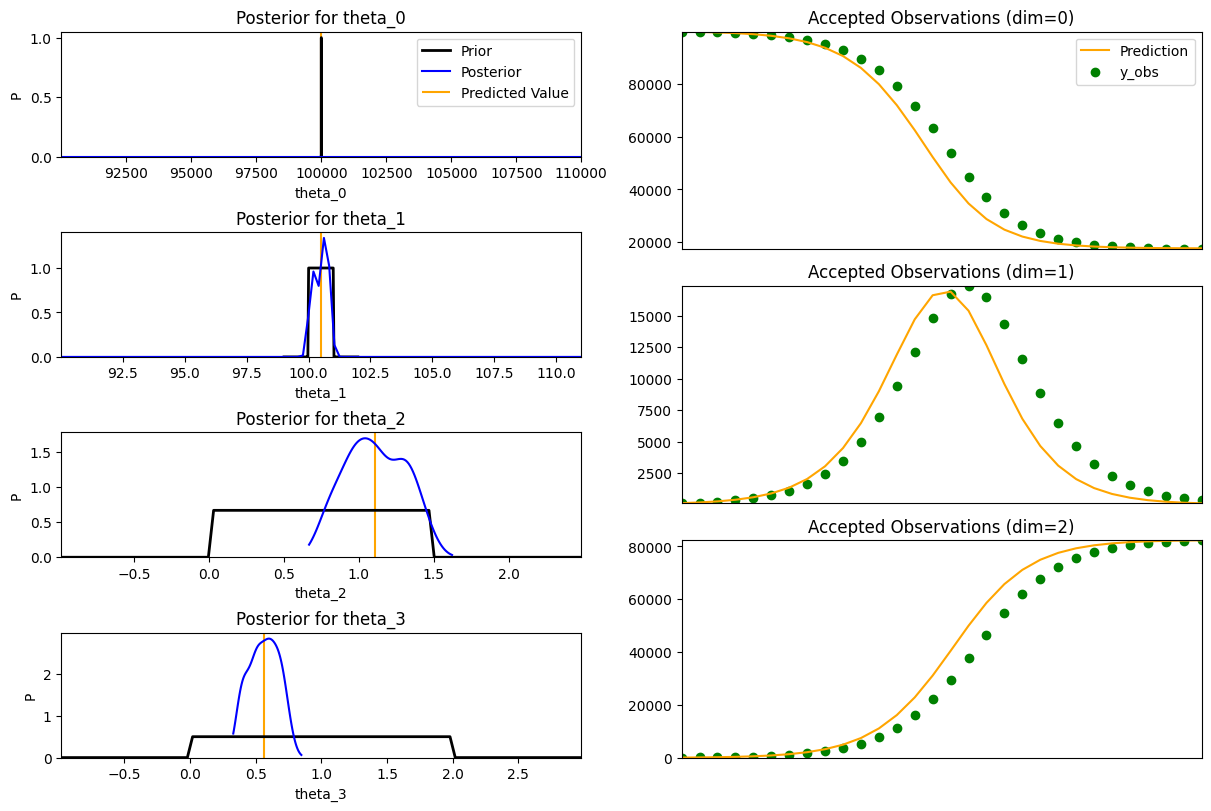

True Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
R_0=2.000

Fitted Model - Population Size=100,000.5
Initially Infected=100.5
Beta=1.108
Gamma=0.562
R_0=1.971

R0 - [2.008,2.018]
RSSE: 4,300.654
Wall time: 17min 57s


In [13]:
%%time
# ABC-SMC \w I peak value & date
np.random.seed(16111998) # Fix random seed

fitted_model,_=ABC.adaptive_abc_smc(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_smc_priors,
    max_steps=100,sample_size=100,max_simulations=4500,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,
    summary_stats=[peak_infections_date_ss,peak_infections_value_ss])

print("True Model - {}\n".format(sir_model))
print("Fitted Model - {}\n".format(fitted_model))

# 90% CI for R0 value
r0_estimate=estimate_r0(accepted_params)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate[0],r0_estimate[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model.observe(),sir_model.observe(),ln=True)))

*Comments*



### Other
Other features to consider when designing summary statistics for SIR models are
 * Comparison between consecutive data points (i.e. conditional on previous data point) due to there being an explict relationship between them.
 * Using logarithms so as to break the multi-plicative expressions into summations.

# Discussion

## Limitations
 TODO

The SIR model described above is very simple, extensions should be introduced so that it can better reflect the real world. Most of these extensions will introduce new model parameters which need to be learned, either requiring more time or decreasing the quality of the overall fit.

## Extensions to the SIR Model

The classical SIR model described above is very rigid. More flexible models consider some of the following dynamics
 * Migration and Natural birth & death rates (e.g. *SIR Model \w Vital Dynamics*). The simplest model would have all briths and immigrants join the sucestible population, but this can be extended (e.g. Add births from removed people to the removed population).
 * Having a sub-population which is not susceptible (but not removed). This could be due to natural immunity or by voluntarily removing themselves from the susceptible population (i.e. self-isolate).
 * Introuce a delay between someone being exposed (i.e. infected) and being infectious (e.g. *SEIR model*). A popular extension is for the exposed population to have a lower, but non-zero, rate of infection compared to the infectious population.
   * The idea of extra groups can be expanded almost infinitely (IRL each person is a unique group): e.g. people who were sick and went to the hospital and thus couldn't infect others; geographic regions; grouped by the risk their profession exposes them too; immuno-compromised people; age; rural vs urban; etc.
 * Allow for people to jump from susceptible to removed (i.e. got infected but were never infectious to others, very mild/no symptoms), or for people to move from removed to susceptible (i.e. immunity wore off).
 * Model a vaccination program, where a certain number of people are vaccinated each day. In the simplest model this would move a certain number of people from $S\to R$ each time-step, but in reality we would not just be vaccinating sucestible people as we may not know who is in each population.
 * Rates of infection and removal $\beta,\gamma$ changing over time, especially seasonally.
 * Having the proportion of cases being detected (i.e. the size of population $I(t)$) being a variable.
 * Remove the Recovered population altogether. This models a disease you can get over and over (e.g. common cold which has a high mutation rate).
 * Stochastic SIR model ($\beta,\gamma$ come from distributions and thus can vary each time-step?)
 * Asymptomatic people *SEAIR Model*.

## Extensions to the ABC Methods

For SIR models we often choose to evaluate the logarithms of each value, rather than their actual value (namely by using the log-distance measure). Computational efficiency can be improved by preprocessing the data st only the logarithmic values are passed to the ABC method (saving the logs having to be computed several times during the algorithm). This may require care around other features of the implementation of the ABC method (e.g. kernels, priors etc.). We could also choose to pre-process for the ratio of values (among other features) but this is less relevant for the SIR model.

There are several other features which we may wish to consider exploiting using the summary statistics:
 * Relationships between consecutive days. (e.g. ratio).
 * Logarithms of values (Makes multiplication into addition).
 * more
 
## Other Epidemic Models
(Graph based?)

Some bayesian.

Some frequentist.